In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

- [Data](#data)
  - [Risk free rate](#risk-free-rate)
  - [Beta](#beta)
  - [BM](#bm)
  - [Trading data](#trading-data)
    - [Monthly trading data](#monthly-trading-data)
    - [Momentum and reversal](#momentum-and-reversal)
- [Merge](#merge)
- [Monthly Factors](#monthly-factors)
  - [市场收益率](#市场收益率)
- [Daily factors](#daily-factors)


# Data

In [3]:
START = '2007-01-01'
END = '2022-03-31'
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID']

## ST

In [4]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [5]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [6]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

ym        rf
0    2007-01  0.002100
1    2007-02  0.002110
2    2007-03  0.002234
3    2007-04  0.002125
4    2007-05  0.002527
5    2007-06  0.002542
6    2007-07  0.002481
7    2007-08  0.002404
..       ...       ...
175  2021-08  0.001941
176  2021-09  0.002033
177  2021-10  0.001998
178  2021-11  0.001963
179  2021-12  0.002026
180  2022-01  0.002014
181  2022-02  0.001921
182  2022-03  0.001918

[183 rows x 2 columns]

## Beta

In [7]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
beta_df.drop(['Beta60','Beta120'],axis=1,inplace=True)
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

secID       ym    beta
0       000001.XSHE  2007-01  0.7949
1       000001.XSHE  2007-02  0.7880
2       000001.XSHE  2007-03  0.8512
3       000001.XSHE  2007-04  0.8642
4       000001.XSHE  2007-05  0.7715
5       000001.XSHE  2007-06  0.4614
6       000001.XSHE  2007-07  0.6423
7       000001.XSHE  2007-08  0.7722
...             ...      ...     ...
501234  689009.XSHG  2021-08  1.0727
501235  689009.XSHG  2021-09  1.0100
501236  689009.XSHG  2021-10  0.8570
501237  689009.XSHG  2021-11  0.7546
501238  689009.XSHG  2021-12  0.5898
501239  689009.XSHG  2022-01  0.5326
501240  689009.XSHG  2022-02  0.5294
501241  689009.XSHG  2022-03  0.5710

[501242 rows x 3 columns]

## BM

In [8]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

secID       ym        bm
0       000001.XSHE  2007-01  0.162639
1       000001.XSHE  2007-02  0.163321
2       000001.XSHE  2007-03  0.176236
3       000001.XSHE  2007-04  0.140732
4       000001.XSHE  2007-05  0.127291
5       000001.XSHE  2007-06  0.123739
6       000001.XSHE  2007-07  0.093992
7       000001.XSHE  2007-08  0.097085
...             ...      ...       ...
500888  689009.XSHG  2021-08  0.076097
500889  689009.XSHG  2021-09  0.070547
500890  689009.XSHG  2021-10  0.092734
500891  689009.XSHG  2021-11  0.097551
500892  689009.XSHG  2021-12  0.084318
500893  689009.XSHG  2022-01  0.097158
500894  689009.XSHG  2022-02  0.103561
500895  689009.XSHG  2022-03  0.108407

[494110 rows x 3 columns]

## Trading data

In [9]:
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   'preClosePrice',"closePrice",
#                                                   "negMarketValue",
#                                                   "turnoverValue",'turnoverRate'],pandas="1")

# stk_df.to_pickle('./data/stk_df.pkl')

In [10]:
# stk_df = pd.read_pickle('./data/stk_df.pkl')
# stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
# stk_df.sort_values(['secID','tradeDate'],inplace=True)
# # drop ST stocks
# print(stk_df.shape)
# stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
# stk_df = stk_df[stk_df['STflg'].isna()].copy()
# stk_df.drop('STflg',axis=1,inplace=True)
# print(stk_df.shape)

In [11]:
# # # If the trading days are required to be consecutive, fill missing days first. This could possibly produce a much larger df when using 
# ## daily data, and if the missing dates are a lot for some securities

# def fill_missing(df, full_dates, id_col='secID', date_col='tradeDate'):
#     """
#     This function fills the missing dates for stocks.
#     Parameters:
#         df: The dataframe. Could be a sub-dataframe created by "groupby".
#             The dataframe must be sorted on the "date_col".
#         full_dates: the unique dates covering all securities in the full dataframe. 
#                     Need to be sorted.
#         id_col: the security id.
#         date_col: the dates column for the security
#     Returns:
#         A dataframe with the missing dates filled with NA.
#     """
#     stk_id = df[id_col].unique()
#     # Newer version of pandas will allow comparison between "Timestamp" and "datetime64"
# #     date_start = np.where(full_dates == df[date_col].min())[0][0] 
# #     date_end = np.where(full_dates == df[date_col].max())[0][0]
#     date_start = np.where(full_dates == df[date_col].min().to_datetime64())[0][0] 
#     date_end = np.where(full_dates == df[date_col].max().to_datetime64())[0][0]
#     dates = full_dates[date_start:date_end+1]
#     idx = pd.MultiIndex.from_product([stk_id,dates],
#                                      names=(id_col,date_col))
#     df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
#     return df

In [12]:
# full_dates = np.sort(stk_df['tradeDate'].unique())

In [13]:
# %%time
# stk_df = stk_df.groupby('secID').apply(fill_missing, full_dates=full_dates)

In [14]:
# stk_df.reset_index(drop=True, inplace=True)

# stk_df['ret_daily'] = stk_df['closePrice'] / stk_df['preClosePrice'] - 1
# stk_df['illiq_daily'] = abs(stk_df['ret_daily']) / stk_df['turnoverValue']

# stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

In [15]:
# stk_df.to_pickle('./data/stk_df_filled.pkl')

In [16]:
stk_df = pd.read_pickle('./data/stk_df_filled.pkl')

In [17]:
stk_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
1         000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
2         000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
3         000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
4         000001.XSHE 2007-06-26            NaN         NaN             NaN   
5         000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
6         000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
7         000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
...               ...        ...            ...         ...             ...   
10182920  900957.XSHG 2022-03-03          0.610       0.614    1.120560e+08   
10182921  900957.XSHG 2022-03-04          0.614       0.611    1.115040e+08   
10182922  900957.XSHG 2022-03-07          0.611       0.605    1.104000e+08   
10182923  900957.XSHG 2022-03-08          0.605       0.604    1.102160e+08   
10182924  900957.XSHG 2022-03-09          0.604       0.600    1.094800e+08   
10182925  900957.XSHG 2022-03-10          0.600       0.605    1.104000e+08   
10182926  900957.XSHG 2022-03-11          0.605       0.606    1.105840e+08   
10182927  900957.XSHG 2022-03-14          0.606       0.594    1.083760e+08   

          turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  
0          4.182345e+09        0.0840   0.197544  4.723272e-11  2007-06  
1          2.285485e+09        0.0440   0.100033  4.376871e-11  2007-06  
2          2.761567e+09        0.0510   0.031769  1.150402e-11  2007-06  
3          2.324186e+09        0.0426  -0.005650  2.430837e-12  2007-06  
4                   NaN           NaN        NaN           NaN  2007-06  
5          2.446556e+09        0.0489  -0.084659  3.460334e-11  2007-06  
6          1.617434e+09        0.0336  -0.064557  3.991295e-11  2007-06  
7          1.410758e+09        0.0316  -0.086928  6.161781e-11  2007-06  
...                 ...           ...        ...           ...      ...  
10182920   4.576100e+04        0.0004   0.006557  1.432962e-07  2022-03  
10182921   3.987800e+04        0.0004  -0.004886  1.225235e-07  2022-03  
10182922   1.825430e+05        0.0016  -0.009820  5.379536e-08  2022-03  
10182923   1.612110e+05        0.0015  -0.001653  1.025298e-08  2022-03  
10182924   1.285010e+05        0.0012  -0.006623  5.153669e-08  2022-03  
10182925   7.845200e+04        0.0007   0.008333  1.062221e-07  2022-03  
10182926   7.993400e+04        0.0007   0.001653  2.067822e-08  2022-03  
10182927   1.005700e+05        0.0009  -0.019802  1.968975e-07  2022-03  

[10182928 rows x 10 columns]

### Monthly trading data

In [18]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['tradeDate','preClosePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']
stk_df_m.sort_values(['secID','ym'],inplace=True)
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)
stk_df_m

secID       ym  closePrice        mktcap  turnoverValue  \
0       000001.XSHE  2007-06     870.870  4.266117e+10   1.410758e+09   
1391    000001.XSHE  2007-07    1146.498  5.616330e+10   1.479466e+09   
2790    000001.XSHE  2007-08    1202.510  5.890714e+10   6.552881e+08   
4215    000001.XSHE  2007-09    1265.167  6.197651e+10   1.408136e+09   
5655    000001.XSHE  2007-10    1520.542  7.448652e+10   1.440425e+09   
7101    000001.XSHE  2007-11    1141.751  5.593078e+10   5.452159e+08   
8563    000001.XSHE  2007-12    1221.497  6.574629e+10   1.019671e+09   
10047   000001.XSHE  2008-01    1053.778  5.850212e+10   5.328429e+08   
...             ...      ...         ...           ...            ...   
469360  900957.XSHG  2021-08       0.612  1.116880e+08   3.033640e+05   
473762  900957.XSHG  2021-09       0.667  1.218080e+08   2.086830e+05   
478193  900957.XSHG  2021-10       0.640  1.168400e+08   6.162200e+04   
482656  900957.XSHG  2021-11       0.614  1.120560e+08   1.161060e+05   
487164  900957.XSHG  2021-12       0.636  1.161040e+08   1.059960e+05   
491702  900957.XSHG  2022-01       0.622  1.135280e+08   1.319240e+05   
496253  900957.XSHG  2022-02       0.615  1.122400e+08   9.851400e+04   
500813  900957.XSHG  2022-03       0.594  1.083760e+08   1.005700e+05   

        turnoverRate  ret_daily   illiq_daily       ret       size        rf  \
0             0.0316  -0.086928  6.161781e-11       NaN  24.476555  0.002542   
1391          0.0270   0.059356  4.012016e-11  0.316497  24.751529  0.002481   
2790          0.0112   0.007958  1.214425e-11  0.048855  24.799228  0.002404   
4215          0.0228   0.030147  2.140927e-11  0.052105  24.850021  0.002621   
5655          0.0200   0.065410  4.541049e-11  0.201851  25.033884  0.003095   
7101          0.0096  -0.026181  4.801976e-11 -0.249116  24.747381  0.003780   
8563          0.0154  -0.010256  1.005854e-11  0.069845  24.909069  0.003011   
10047         0.0089  -0.019146  3.593101e-11 -0.137306  24.792329  0.002949   
...              ...        ...           ...       ...        ...       ...   
469360        0.0027  -0.022364  7.372074e-08 -0.058462  18.531220  0.001941   
473762        0.0017   0.018321  8.779158e-08  0.089869  18.617957  0.002033   
478193        0.0005   0.006289  1.020627e-07 -0.040480  18.576316  0.001998   
482656        0.0010  -0.014446  1.244228e-07 -0.040625  18.534509  0.001963   
487164        0.0009   0.001575  1.485719e-08  0.035831  18.569997  0.002026   
491702        0.0012   0.008104  6.142724e-08 -0.022013  18.547560  0.002014   
496253        0.0009  -0.001623  1.647864e-08 -0.011254  18.536150  0.001921   
500813        0.0009  -0.019802  1.968975e-07 -0.034146  18.501117  0.001918   

           exret  
0            NaN  
1391    0.314016  
2790    0.046451  
4215    0.049484  
5655    0.198756  
7101   -0.252896  
8563    0.066834  
10047  -0.140255  
...          ...  
469360 -0.060402  
473762  0.087837  
478193 -0.042478  
482656 -0.042588  
487164  0.033805  
491702 -0.024027  
496253 -0.013175  
500813 -0.036064  

[507467 rows x 12 columns]

In [19]:
stk_df_m[stk_df_m['secID'] == '000001.XSHE'].set_index('ym').loc['2010-01':'2010-12']
# 停牌的时间都填充为NaN。刚恢复交易的第一个月的月收益率也为NaN

secID  closePrice        mktcap  turnoverValue  turnoverRate  \
ym                                                                            
2010-01  000001.XSHE     895.357  6.345328e+10   5.284377e+08        0.0082   
2010-02  000001.XSHE     926.303  6.564637e+10   1.008966e+09        0.0154   
2010-03  000001.XSHE     957.248  6.783945e+10   7.105142e+08        0.0104   
2010-04  000001.XSHE     848.320  6.011979e+10   6.628292e+08        0.0111   
2010-05  000001.XSHE     722.475  5.120124e+10   4.806838e+08        0.0092   
2010-06  000001.XSHE     722.475  5.437499e+10   5.491348e+08        0.0099   
2010-07  000001.XSHE         NaN           NaN            NaN           NaN   
2010-08  000001.XSHE         NaN           NaN            NaN           NaN   
2010-09  000001.XSHE     669.249  5.036906e+10   3.472608e+08        0.0069   
2010-10  000001.XSHE     759.610  5.716982e+10   6.635094e+08        0.0115   
2010-11  000001.XSHE     676.263  5.089697e+10   4.642922e+08        0.0091   
2010-12  000001.XSHE     651.507  4.903361e+10   3.783178e+08        0.0078   

         ret_daily   illiq_daily       ret       size        rf     exret  
ym                                                                         
2010-01  -0.002299  4.350204e-12 -0.109561  24.873570  0.001511 -0.111072  
2010-02   0.013544  1.342342e-11  0.034563  24.907548  0.001547  0.033016  
2010-03  -0.019028  2.678085e-11  0.033407  24.940410  0.001450  0.031957  
2010-04   0.019336  2.917199e-11 -0.113793  24.819605  0.001464 -0.115256  
2010-05  -0.031527  6.558795e-11 -0.148346  24.659030  0.002081 -0.150427  
2010-06  -0.053001  9.651729e-11  0.000000  24.719170  0.003236 -0.003236  
2010-07        NaN           NaN       NaN        NaN  0.001798       NaN  
2010-08        NaN           NaN       NaN        NaN  0.002369       NaN  
2010-09  -0.002459  7.082247e-12       NaN  24.642643  0.002922       NaN  
2010-10  -0.019178  2.890457e-11  0.135019  24.769292  0.002214  0.132805  
2010-11  -0.019737  4.250943e-11 -0.109723  24.653069  0.003092 -0.112815  
2010-12   0.007659  2.024503e-11 -0.036607  24.615772  0.005141 -0.041748

### Momentum and reversal

#### Using unfilled data

In [20]:
stk_unfilled_df = pd.read_pickle('./data/stk_df.pkl')
stk_unfilled_df['tradeDate'] = pd.to_datetime(stk_unfilled_df['tradeDate'], format='%Y-%m-%d')
stk_unfilled_df['ym'] = stk_unfilled_df['tradeDate'].dt.to_period('M')
stk_unfilled_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_unfilled_df.shape)
stk_unfilled_df = pd.merge(stk_unfilled_df, st_df, on=['secID','tradeDate'],how='left')
stk_unfilled_df = stk_unfilled_df[stk_unfilled_df['STflg'].isna()].copy()
stk_unfilled_df.drop('STflg',axis=1,inplace=True)
print(stk_unfilled_df.shape)
# Monthly
stk_unfilled_df_m = stk_unfilled_df.groupby(['secID','ym'],as_index=False).last()

(9934190, 8)
(9535739, 8)


In [21]:
stk_unfilled_df_m['ret_mom'] = stk_unfilled_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret
stk_unfilled_df_m.sort_values(['secID','ym'],inplace=True)
stk_unfilled_df_m['1+ret_mom'] = stk_unfilled_df_m['ret_mom'] + 1

In [22]:
stk_unfilled_df_m['mom'] = stk_unfilled_df_m.groupby('secID').rolling(11,min_periods=9)['1+ret_mom'].apply(np.prod, raw=True).values - 1

In [23]:
stk_df_m = pd.merge(stk_df_m, stk_unfilled_df_m[['secID','ym','1+ret_mom']],on=['secID','ym'],how='left')
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 

In [24]:
stk_df_m['rev'] = stk_df_m['exret'].values
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['rf'] = stk_df_m.groupby(['secID'])['rf'].shift(-1)
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [25]:
stk_df_m.drop(['ret_daily','turnoverValue','turnoverRate','illiq_daily','1+ret_mom'],axis=1,inplace=True)

In [26]:
stk_df_m

secID       ym  closePrice        mktcap       ret       size  \
0       000001.XSHE  2007-06     870.870  4.266117e+10  0.316497  24.476555   
1       000001.XSHE  2007-07    1146.498  5.616330e+10  0.048855  24.751529   
2       000001.XSHE  2007-08    1202.510  5.890714e+10  0.052105  24.799228   
3       000001.XSHE  2007-09    1265.167  6.197651e+10  0.201851  24.850021   
4       000001.XSHE  2007-10    1520.542  7.448652e+10 -0.249116  25.033884   
5       000001.XSHE  2007-11    1141.751  5.593078e+10  0.069845  24.747381   
6       000001.XSHE  2007-12    1221.497  6.574629e+10 -0.137306  24.909069   
7       000001.XSHE  2008-01    1053.778  5.850212e+10 -0.004504  24.792329   
...             ...      ...         ...           ...       ...        ...   
507459  900957.XSHG  2021-08       0.612  1.116880e+08  0.089869  18.531220   
507460  900957.XSHG  2021-09       0.667  1.218080e+08 -0.040480  18.617957   
507461  900957.XSHG  2021-10       0.640  1.168400e+08 -0.040625  18.576316   
507462  900957.XSHG  2021-11       0.614  1.120560e+08  0.035831  18.534509   
507463  900957.XSHG  2021-12       0.636  1.161040e+08 -0.022013  18.569997   
507464  900957.XSHG  2022-01       0.622  1.135280e+08 -0.011254  18.547560   
507465  900957.XSHG  2022-02       0.615  1.122400e+08 -0.034146  18.536150   
507466  900957.XSHG  2022-03       0.594  1.083760e+08       NaN  18.501117   

              rf     exret       mom       rev ret_date mom_date  
0       0.002481  0.314016       NaN       NaN  2007-07      NaT  
1       0.002404  0.046451       NaN  0.314016  2007-08  2007-06  
2       0.002621  0.049484       NaN  0.046451  2007-09  2007-07  
3       0.003095  0.198756       NaN  0.049484  2007-10  2007-08  
4       0.003780 -0.252896       NaN  0.198756  2007-11  2007-09  
5       0.003011  0.066834       NaN -0.252896  2007-12  2007-10  
6       0.002949 -0.140255       NaN  0.066834  2008-01  2007-11  
7       0.002946 -0.007450       NaN -0.140255  2008-02  2007-12  
...          ...       ...       ...       ...      ...      ...  
507459  0.002033  0.087837  0.183971 -0.060402  2021-09  2021-07  
507460  0.001998 -0.042478  0.186047  0.087837  2021-10  2021-08  
507461  0.001963 -0.042588  0.285164 -0.042478  2021-11  2021-09  
507462  0.002026  0.033805  0.216730 -0.042588  2021-12  2021-10  
507463  0.002014 -0.024027  0.211045  0.033805  2022-01  2021-11  
507464  0.001921 -0.013175 -0.059172 -0.024027  2022-02  2021-12  
507465  0.001918 -0.036064 -0.157182 -0.013175  2022-03  2022-01  
507466       NaN       NaN -0.117647 -0.036064      NaT  2022-02  

[507467 rows x 12 columns]

# Merge

In [27]:
ret_df = pd.merge(stk_df_m[['secID','ret_date','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'], how='left')

In [28]:
ret_df

secID ret_date       ret        rf     exret       ym  \
0       000001.XSHE  2007-07  0.316497  0.002481  0.314016  2007-06   
1       000001.XSHE  2007-08  0.048855  0.002404  0.046451  2007-07   
2       000001.XSHE  2007-09  0.052105  0.002621  0.049484  2007-08   
3       000001.XSHE  2007-10  0.201851  0.003095  0.198756  2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003780 -0.252896  2007-10   
5       000001.XSHE  2007-12  0.069845  0.003011  0.066834  2007-11   
6       000001.XSHE  2008-01 -0.137306  0.002949 -0.140255  2007-12   
7       000001.XSHE  2008-02 -0.004504  0.002946 -0.007450  2008-01   
...             ...      ...       ...       ...       ...      ...   
507459  900957.XSHG  2021-09  0.089869  0.002033  0.087837  2021-08   
507460  900957.XSHG  2021-10 -0.040480  0.001998 -0.042478  2021-09   
507461  900957.XSHG  2021-11 -0.040625  0.001963 -0.042588  2021-10   
507462  900957.XSHG  2021-12  0.035831  0.002026  0.033805  2021-11   
507463  900957.XSHG  2022-01 -0.022013  0.002014 -0.024027  2021-12   
507464  900957.XSHG  2022-02 -0.011254  0.001921 -0.013175  2022-01   
507465  900957.XSHG  2022-03 -0.034146  0.001918 -0.036064  2022-02   
507466  900957.XSHG      NaT       NaN       NaN       NaN  2022-03   

              mktcap       size       rev mom_date       mom    beta  
0       4.266117e+10  24.476555       NaN      NaT       NaN  0.4614  
1       5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423  
2       5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722  
3       6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596  
4       7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988  
5       5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560  
6       6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468  
7       5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654  
...              ...        ...       ...      ...       ...     ...  
507459  1.116880e+08  18.531220 -0.060402  2021-07  0.183971     NaN  
507460  1.218080e+08  18.617957  0.087837  2021-08  0.186047     NaN  
507461  1.168400e+08  18.576316 -0.042478  2021-09  0.285164     NaN  
507462  1.120560e+08  18.534509 -0.042588  2021-10  0.216730     NaN  
507463  1.161040e+08  18.569997  0.033805  2021-11  0.211045     NaN  
507464  1.135280e+08  18.547560 -0.024027  2021-12 -0.059172     NaN  
507465  1.122400e+08  18.536150 -0.013175  2022-01 -0.157182     NaN  
507466  1.083760e+08  18.501117 -0.036064  2022-02 -0.117647     NaN  

[507467 rows x 12 columns]

In [29]:
ret_df = pd.merge(ret_df, pb_df, on=['secID','ym'],how='left')

In [30]:
ret_df

secID ret_date       ret        rf     exret       ym  \
0       000001.XSHE  2007-07  0.316497  0.002481  0.314016  2007-06   
1       000001.XSHE  2007-08  0.048855  0.002404  0.046451  2007-07   
2       000001.XSHE  2007-09  0.052105  0.002621  0.049484  2007-08   
3       000001.XSHE  2007-10  0.201851  0.003095  0.198756  2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003780 -0.252896  2007-10   
5       000001.XSHE  2007-12  0.069845  0.003011  0.066834  2007-11   
6       000001.XSHE  2008-01 -0.137306  0.002949 -0.140255  2007-12   
7       000001.XSHE  2008-02 -0.004504  0.002946 -0.007450  2008-01   
...             ...      ...       ...       ...       ...      ...   
507459  900957.XSHG  2021-09  0.089869  0.002033  0.087837  2021-08   
507460  900957.XSHG  2021-10 -0.040480  0.001998 -0.042478  2021-09   
507461  900957.XSHG  2021-11 -0.040625  0.001963 -0.042588  2021-10   
507462  900957.XSHG  2021-12  0.035831  0.002026  0.033805  2021-11   
507463  900957.XSHG  2022-01 -0.022013  0.002014 -0.024027  2021-12   
507464  900957.XSHG  2022-02 -0.011254  0.001921 -0.013175  2022-01   
507465  900957.XSHG  2022-03 -0.034146  0.001918 -0.036064  2022-02   
507466  900957.XSHG      NaT       NaN       NaN       NaN  2022-03   

              mktcap       size       rev mom_date       mom    beta        bm  
0       4.266117e+10  24.476555       NaN      NaT       NaN  0.4614  0.123739  
1       5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423  0.093992  
2       5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722  0.097085  
3       6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596  0.092276  
4       7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988  0.083411  
5       5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560  0.111084  
6       6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468  0.094476  
7       5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654  0.109513  
...              ...        ...       ...      ...       ...     ...       ...  
507459  1.116880e+08  18.531220 -0.060402  2021-07  0.183971     NaN       NaN  
507460  1.218080e+08  18.617957  0.087837  2021-08  0.186047     NaN       NaN  
507461  1.168400e+08  18.576316 -0.042478  2021-09  0.285164     NaN       NaN  
507462  1.120560e+08  18.534509 -0.042588  2021-10  0.216730     NaN       NaN  
507463  1.161040e+08  18.569997  0.033805  2021-11  0.211045     NaN       NaN  
507464  1.135280e+08  18.547560 -0.024027  2021-12 -0.059172     NaN       NaN  
507465  1.122400e+08  18.536150 -0.013175  2022-01 -0.157182     NaN       NaN  
507466  1.083760e+08  18.501117 -0.036064  2022-02 -0.117647     NaN       NaN  

[507467 rows x 13 columns]

# Monthly Factors

In [31]:
def double_sort(df, sort1, sort2='size', group_date='ym', merge_cols=['secID','ret_date']):
    """
    Double sorting. 
    Arguments:
        sort1: variable 1 for sorting into 3 groups
        sort2: default is "size", sorting into 2 groups
    returns:
        portfolios containing 2*3 groups
    """
    q1 = dict()
    keys = [f'q_{sort1}_1',f'q_{sort1}_2']
    values = [0.3, 0.7]
    q1.update(zip(keys,values))

    q2 = dict()
    keys = [f'q_{sort2}_1']
    values = [0.5]
    q2.update(zip(keys,values))

    q1_df = pd.DataFrame()
    for key, value in q1.items():
        q1_df[key] = df.groupby([group_date])[sort1].quantile(value)
    
    q2_df = pd.DataFrame()
    for key, value in q2.items():
        q2_df[key] = df.groupby([group_date])[sort2].quantile(value)

    ret_df_q = pd.merge(df, q2_df, on=group_date)
    ret_df_q = pd.merge(ret_df_q, q1_df, on=group_date)

    portfolios1 = dict()
    portfolios1[f'{sort1}1'] = ret_df_q.loc[ret_df_q[f'{sort1}'] <= ret_df_q[f'q_{sort1}_1']]
    portfolios1[f'{sort1}2'] = ret_df_q.loc[(ret_df_q[f'{sort1}'] >= ret_df_q[f'q_{sort1}_1']) & \
                                            (ret_df_q[f'{sort1}'] <= ret_df_q[f'q_{sort1}_2'])]
    portfolios1[f'{sort1}3'] = ret_df_q.loc[ret_df_q[f'{sort1}'] >= ret_df_q[f'q_{sort1}_2']]

    portfolios2 = dict()
    portfolios2[f'{sort2}1'] = ret_df_q.loc[ret_df_q[f'{sort2}'] <= ret_df_q[f'q_{sort2}_1'],
                                            merge_cols+[group_date]+['ret','exret','size','mktcap']]
    portfolios2[f'{sort2}2'] = ret_df_q.loc[ret_df_q[f'{sort2}'] >= ret_df_q[f'q_{sort2}_1'],
                                            merge_cols+[group_date]+['ret','exret','size','mktcap']]

    portfolios = dict()
    for group1 in portfolios1.keys():
        for group2 in portfolios2.keys():
            portfolios[f'{group1}_{group2}'] = pd.merge(portfolios2[group2],
                                                        portfolios1[group1][merge_cols+[f'{sort1}']],
                                                        on=merge_cols)
    return portfolios

In [32]:
def factor(df, sort1, sort2='size', long_high=True, long_only=True):
    portfolios = double_sort(df=df, sort1=sort1, sort2=sort2)
    portfolios_vwret = {}
    for pf in portfolios.keys():
    #     portfolios[pf].dropna(inplace=True) # 不应该dropna。如果在某个月停牌，分组时在前一个月，并不知道会这样。
        temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
        portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
        portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
        portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
        portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

    portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
    portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
    portfolios_vwret_df.columns = portfolios_vwret.keys()
    if long_only:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
    else:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
    factor.name = sort1
    return factor

In [33]:
# factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = factor(df=ret_df,sort1=f,long_high=False)
    else:
        factors_dict[f] = factor(df=ret_df,sort1=f)

In [34]:
factors_df = pd.DataFrame(factors_dict)

In [35]:
# Size
sort1 = 'bm'
portfolios = double_sort(ret_df,sort1=sort1)
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_df['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 

In [36]:
factors_df

bm       mom       rev      size
ret_date                                        
2007-02   0.225507       NaN       NaN  0.197290
2007-03   0.181880       NaN  0.121655  0.194629
2007-04   0.365498       NaN  0.281322  0.333786
2007-05   0.082580       NaN  0.100779  0.070302
2007-06  -0.172057       NaN -0.135300 -0.189340
2007-07   0.252825       NaN  0.307959  0.263211
2007-08   0.151364       NaN  0.117534  0.088721
2007-09   0.052301       NaN  0.015507  0.028394
...            ...       ...       ...       ...
2021-08   0.078989  0.057667  0.015628  0.057349
2021-09   0.021044 -0.034337  0.009088 -0.024096
2021-10  -0.037577  0.003608  0.008295 -0.022542
2021-11   0.043381  0.063753  0.078677  0.137159
2021-12   0.069567 -0.009271  0.046222  0.037392
2022-01  -0.041801 -0.118946 -0.111440 -0.085123
2022-02   0.043367  0.059530  0.049949  0.050449
2022-03  -0.042582 -0.074289 -0.077184 -0.050927

[182 rows x 4 columns]

## 市场收益率

In [37]:
shibor_df

tradeDate        rf       ym
0    2007-01-04  0.002148  2007-01
1    2007-01-05  0.002143  2007-01
2    2007-01-08  0.002132  2007-01
3    2007-01-09  0.002131  2007-01
4    2007-01-10  0.002122  2007-01
5    2007-01-11  0.002112  2007-01
6    2007-01-12  0.002105  2007-01
7    2007-01-15  0.002101  2007-01
...         ...       ...      ...
3786 2022-03-04  0.001917  2022-03
3787 2022-03-07  0.001917  2022-03
3788 2022-03-08  0.001917  2022-03
3789 2022-03-09  0.001917  2022-03
3790 2022-03-10  0.001917  2022-03
3791 2022-03-11  0.001917  2022-03
3792 2022-03-14  0.001917  2022-03
3793 2022-03-15  0.001918  2022-03

[3794 rows x 3 columns]

In [38]:
# 用中证800作为market return
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])
index_df['ret_date'] = index_df['tradeDate'].dt.to_period('M')
index_df.sort_values('tradeDate',inplace=True)
index_df = index_df.groupby('ret_date',as_index=False).last()
index_df['mktret'] = index_df['closeIndex'] / index_df['closeIndex'].shift() - 1
index_df = pd.merge(index_df,shibor_df_m,left_on=['ret_date'],right_on=['ym'])
index_df['exmktret'] = index_df['mktret'] - index_df['rf']
index_df.drop(['ym','mktret','indexID','secShortName','tradeDate',
               'closeIndex','CHGPct'],axis=1,inplace=True)
index_df.dropna(inplace=True)

In [39]:
index_df

ret_date        rf  exmktret
1    2007-02  0.002110  0.089095
2    2007-03  0.002234  0.108569
3    2007-04  0.002125  0.291347
4    2007-05  0.002527  0.098653
5    2007-06  0.002542 -0.074613
6    2007-07  0.002481  0.192378
7    2007-08  0.002404  0.167471
8    2007-09  0.002621  0.047576
..       ...       ...       ...
175  2021-08  0.001941  0.014227
176  2021-09  0.002033  0.002219
177  2021-10  0.001998  0.001806
178  2021-11  0.001963 -0.005955
179  2021-12  0.002026  0.018238
180  2022-01  0.002014 -0.085367
181  2022-02  0.001921  0.010795
182  2022-03  0.001918 -0.132191

[182 rows x 3 columns]

In [40]:
factors_df = pd.merge(index_df, factors_df, on='ret_date')
factors_df.set_index('ret_date',inplace=True)
factors_df = factors_df[['rf','exmktret','size','bm','mom','rev']]
factors_df.columns = ['rf','exmktret','size_long','bm_long','mom_long','rev_long']
factors_df

rf  exmktret  size_long   bm_long  mom_long  rev_long
ret_date                                                             
2007-02   0.002110  0.089095   0.197290  0.225507       NaN       NaN
2007-03   0.002234  0.108569   0.194629  0.181880       NaN  0.121655
2007-04   0.002125  0.291347   0.333786  0.365498       NaN  0.281322
2007-05   0.002527  0.098653   0.070302  0.082580       NaN  0.100779
2007-06   0.002542 -0.074613  -0.189340 -0.172057       NaN -0.135300
2007-07   0.002481  0.192378   0.263211  0.252825       NaN  0.307959
2007-08   0.002404  0.167471   0.088721  0.151364       NaN  0.117534
2007-09   0.002621  0.047576   0.028394  0.052301       NaN  0.015507
...            ...       ...        ...       ...       ...       ...
2021-08   0.001941  0.014227   0.057349  0.078989  0.057667  0.015628
2021-09   0.002033  0.002219  -0.024096  0.021044 -0.034337  0.009088
2021-10   0.001998  0.001806  -0.022542 -0.037577  0.003608  0.008295
2021-11   0.001963 -0.005955   0.137159  0.043381  0.063753  0.078677
2021-12   0.002026  0.018238   0.037392  0.069567 -0.009271  0.046222
2022-01   0.002014 -0.085367  -0.085123 -0.041801 -0.118946 -0.111440
2022-02   0.001921  0.010795   0.050449  0.043367  0.059530  0.049949
2022-03   0.001918 -0.132191  -0.050927 -0.042582 -0.074289 -0.077184

[182 rows x 6 columns]

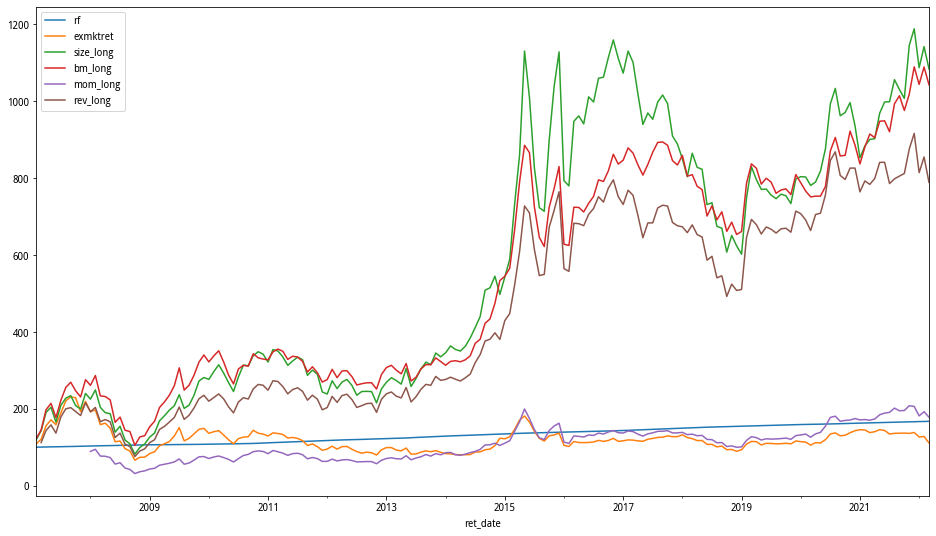

In [41]:
((factors_df+1).cumprod()*100).plot()

In [42]:
factors_df.to_pickle('./data/factors/factors_long_only.pkl')

## Long short factors

In [43]:
# factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = factor(df=ret_df,sort1=f,long_only=False,long_high=False)
    else:
        factors_dict[f] = factor(df=ret_df,sort1=f,long_only=False)

In [44]:
factors_df = pd.DataFrame(factors_dict)

In [45]:
# Size
sort1 = 'bm'
portfolios = double_sort(ret_df,sort1=sort1)
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_df['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 - \
      (portfolios_vwret_df['bm1_size2'] + portfolios_vwret_df['bm2_size2'] + portfolios_vwret_df['bm3_size2']) / 3 

In [46]:
factors_df = pd.merge(index_df, factors_df, on='ret_date')
factors_df.set_index('ret_date',inplace=True)
factors_df = factors_df[['rf','exmktret','size','bm','mom','rev']]
factors_df

rf  exmktret      size        bm       mom       rev
ret_date                                                            
2007-02   0.002110  0.089095  0.076096  0.139221       NaN       NaN
2007-03   0.002234  0.108569  0.080259  0.057221       NaN -0.049465
2007-04   0.002125  0.291347  0.039065  0.099404       NaN -0.067932
2007-05   0.002527  0.098653 -0.026096  0.010264       NaN  0.029636
2007-06   0.002542 -0.074613 -0.112510 -0.066675       NaN -0.004885
2007-07   0.002481  0.192378  0.067658  0.050950       NaN  0.117932
2007-08   0.002404  0.167471 -0.077035  0.052345       NaN -0.006491
2007-09   0.002621  0.047576 -0.020228  0.029152       NaN -0.033810
...            ...       ...       ...       ...       ...       ...
2021-08   0.001941  0.014227  0.014352  0.074199  0.038196 -0.062430
2021-09   0.002033  0.002219 -0.025703  0.060019 -0.053659  0.057943
2021-10   0.001998  0.001806 -0.017339 -0.056599  0.025714  0.033126
2021-11   0.001963 -0.005955  0.123430 -0.046532 -0.024797  0.006545
2021-12   0.002026  0.018238  0.016352  0.089343 -0.067536  0.061749
2022-01   0.002014 -0.085367  0.000233  0.081621 -0.048670 -0.026194
2022-02   0.001921  0.010795  0.021513  0.010809  0.043676  0.015243
2022-03   0.001918 -0.132191  0.028745  0.038077 -0.006099 -0.019145

[182 rows x 6 columns]

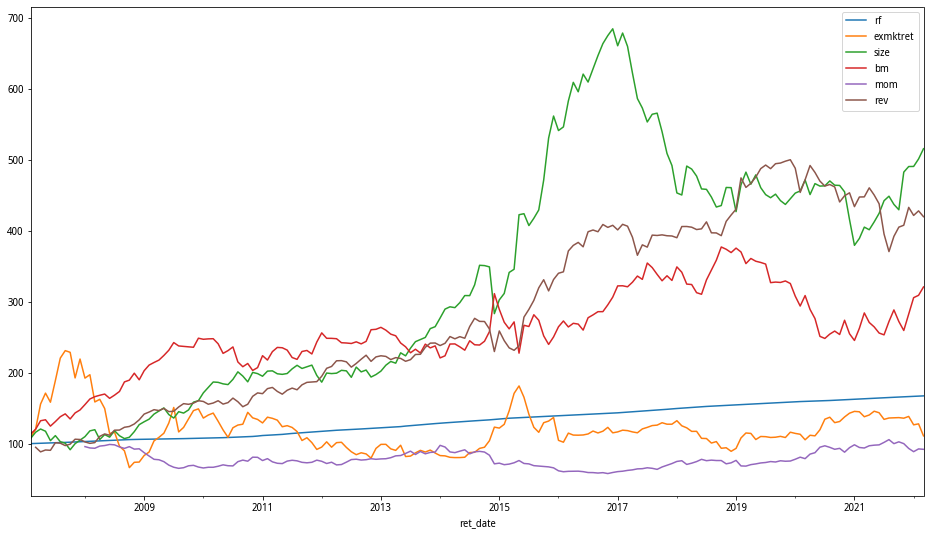

In [47]:
((factors_df+1).cumprod()*100).plot()

In [48]:
factors_df.to_pickle('./data/factors/factors.pkl')

# Daily factors

In [49]:
shibor1d = DataAPI.MktIborGet(secID="Shibor1D.IRCN",beginDate=START,endDate=END,field=['tradeDate','rate'],pandas="1")
shibor1d['tradeDate'] = pd.to_datetime(shibor1d['tradeDate'])
shibor1d['rate'] = shibor1d['rate'] * 0.01 / 365
shibor1d.rename(columns={'rate':'rf'},inplace=True)

In [50]:
def daily_factor(df, sort1, sort2='size', long_high=True, long_only=True):
    
    portfolios = double_sort(df=df, sort1=sort1, sort2=sort2)
    portfolios_vwret = {}
    for pf in portfolios.keys():
        temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
        portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
        portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
        df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                       stk_df[['secID','tradeDate','ym','ret_daily']],
                       left_on=['secID','ret_date'],
                       right_on=['secID','ym'])
        df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
        portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

    portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
    portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
    portfolios_vwret_df.columns = portfolios_vwret.keys()
    if long_only:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
    else:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
    return factor

In [51]:
# Daily factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_high=False)
    else:
        factors_dict[f] = daily_factor(df=ret_df,sort1=f)

In [52]:
factors_daily = pd.DataFrame(factors_dict)

In [53]:
# The size daily factor
portfolios = double_sort(df=ret_df,sort1='bm')
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                   stk_df[['secID','tradeDate','ym','ret_daily']],
                   left_on=['secID','ret_date'],
                   right_on=['secID','ym'])
    df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
    portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_daily['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3

In [54]:
factors_daily

bm       mom       rev      size
tradeDate                                         
2007-02-01  0.013041       NaN       NaN  0.008327
2007-02-02 -0.018846       NaN       NaN -0.015797
2007-02-05  0.009846       NaN       NaN  0.015023
2007-02-06  0.028806       NaN       NaN  0.028548
2007-02-07  0.013814       NaN       NaN  0.013623
2007-02-08  0.020907       NaN       NaN  0.018609
2007-02-09 -0.001954       NaN       NaN  0.000746
2007-02-12  0.025847       NaN       NaN  0.023732
...              ...       ...       ...       ...
2022-03-03  0.008643 -0.007450 -0.007586 -0.001250
2022-03-04 -0.012217 -0.014437 -0.010430 -0.012156
2022-03-07 -0.010252 -0.019411 -0.024816 -0.011582
2022-03-08 -0.028670 -0.030806 -0.025437 -0.032090
2022-03-09 -0.015098 -0.003501 -0.014331 -0.012455
2022-03-10  0.012265  0.021393  0.014468  0.017002
2022-03-11  0.007063  0.001616  0.007645  0.007936
2022-03-14 -0.022444 -0.030809 -0.026685 -0.026434

[3674 rows x 4 columns]

In [55]:
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])

index_df = pd.merge(shibor1d,index_df[['tradeDate','CHGPct']],on='tradeDate')
index_df.rename(columns={'CHGPct':'mktret'},inplace=True)
index_df['exmktret'] = index_df['mktret'] - index_df['rf']

In [56]:
index_df

tradeDate        rf    mktret  exmktret
0    2007-01-04  0.000039  0.009605  0.009566
1    2007-01-05  0.000038  0.008121  0.008083
2    2007-01-08  0.000038  0.032249  0.032211
3    2007-01-09  0.000037  0.029767  0.029730
4    2007-01-10  0.000037  0.025520  0.025483
5    2007-01-11  0.000037 -0.007034 -0.007071
6    2007-01-12  0.000036 -0.028233 -0.028269
7    2007-01-15  0.000036  0.053024  0.052988
...         ...       ...       ...       ...
3687 2022-03-04  0.000052 -0.011156 -0.011208
3688 2022-03-07  0.000056 -0.029342 -0.029398
3689 2022-03-08  0.000056 -0.023603 -0.023659
3690 2022-03-09  0.000055 -0.011621 -0.011676
3691 2022-03-10  0.000055  0.016119  0.016064
3692 2022-03-11  0.000056  0.004642  0.004586
3693 2022-03-14  0.000057 -0.028821 -0.028878
3694 2022-03-15  0.000057 -0.048404 -0.048461

[3695 rows x 4 columns]

In [59]:
factors_daily = pd.merge(index_df[['tradeDate','rf','exmktret']],factors_daily, on='tradeDate')

factors_daily.set_index('tradeDate',inplace=True)

factors_daily = factors_daily[['rf','exmktret','size','bm','mom','rev']]

In [61]:
factors_daily.columns = ['rf','exmktret','size_long','bm_long','mom_long','rev_long']

In [62]:
factors_daily

rf  exmktret  size_long   bm_long  mom_long  rev_long
tradeDate                                                              
2007-02-01  0.000048  0.005542   0.008327  0.013041       NaN       NaN
2007-02-02  0.000048 -0.035335  -0.015797 -0.018846       NaN       NaN
2007-02-05  0.000048 -0.005993   0.015023  0.009846       NaN       NaN
2007-02-06  0.000049  0.019879   0.028548  0.028806       NaN       NaN
2007-02-07  0.000050  0.021923   0.013623  0.013814       NaN       NaN
2007-02-08  0.000052  0.017380   0.018609  0.020907       NaN       NaN
2007-02-09  0.000076 -0.003355   0.000746 -0.001954       NaN       NaN
2007-02-12  0.000110  0.033455   0.023732  0.025847       NaN       NaN
...              ...       ...        ...       ...       ...       ...
2022-03-03  0.000047 -0.005066  -0.001250  0.008643 -0.007450 -0.007586
2022-03-04  0.000052 -0.011208  -0.012156 -0.012217 -0.014437 -0.010430
2022-03-07  0.000056 -0.029398  -0.011582 -0.010252 -0.019411 -0.024816
2022-03-08  0.000056 -0.023659  -0.032090 -0.028670 -0.030806 -0.025437
2022-03-09  0.000055 -0.011676  -0.012455 -0.015098 -0.003501 -0.014331
2022-03-10  0.000055  0.016064   0.017002  0.012265  0.021393  0.014468
2022-03-11  0.000056  0.004586   0.007936  0.007063  0.001616  0.007645
2022-03-14  0.000057 -0.028878  -0.026434 -0.022444 -0.030809 -0.026685

[3674 rows x 6 columns]

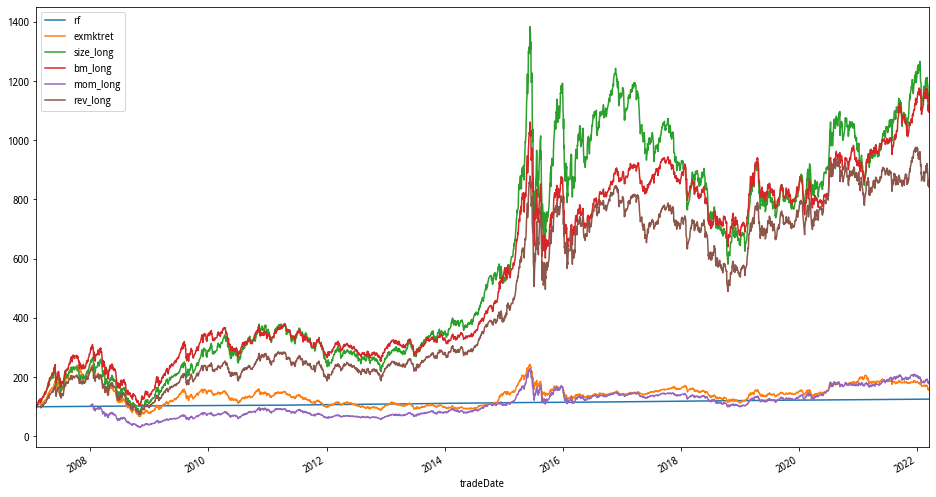

In [63]:
((factors_daily+1).cumprod()*100).plot()

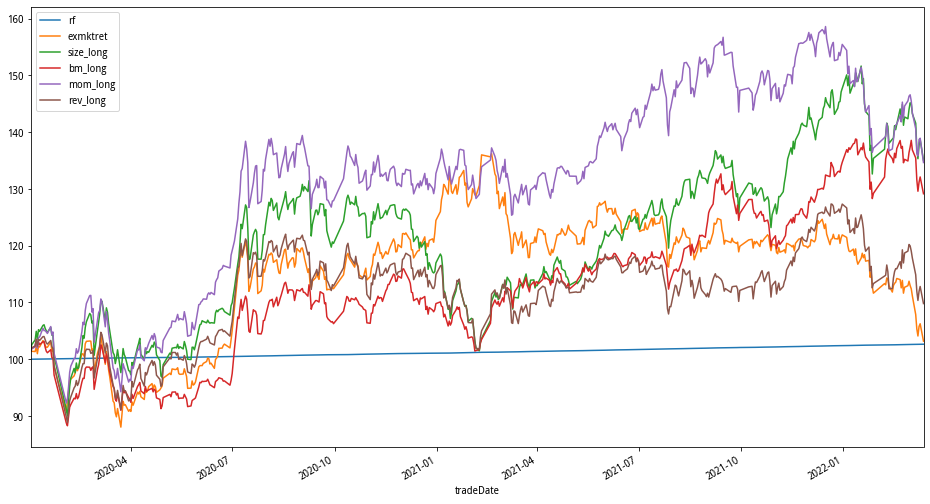

In [65]:
((factors_daily.loc['2020':]+1).cumprod()*100).plot()

In [66]:
# factors_daily.to_pickle('./data/factors/factors_daily_long_only.pkl')

## Long short factors

In [69]:
# Daily factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_only=False,long_high=False)
    else:
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_only=False)

In [70]:
factors_daily = pd.DataFrame(factors_dict)

In [71]:
# The size daily factor
portfolios = double_sort(df=ret_df,sort1='bm')
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                   stk_df[['secID','tradeDate','ym','ret_daily']],
                   left_on=['secID','ret_date'],
                   right_on=['secID','ym'])
    df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
    portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_daily['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 - \
      (portfolios_vwret_df['bm1_size2'] + portfolios_vwret_df['bm2_size2'] + portfolios_vwret_df['bm3_size2']) / 3 

In [72]:
factors_daily

bm       mom       rev      size
tradeDate                                         
2007-02-01  0.008284       NaN       NaN  0.000706
2007-02-02  0.011413       NaN       NaN  0.017586
2007-02-05  0.009377       NaN       NaN  0.019517
2007-02-06  0.005161       NaN       NaN  0.007078
2007-02-07 -0.003939       NaN       NaN -0.007519
2007-02-08  0.004336       NaN       NaN  0.000016
2007-02-09  0.000447       NaN       NaN  0.003784
2007-02-12 -0.006304       NaN       NaN -0.009223
...              ...       ...       ...       ...
2022-03-03  0.022054 -0.004624 -0.007673  0.002299
2022-03-04 -0.000821 -0.004413  0.004745 -0.000821
2022-03-07  0.015438  0.001816 -0.013664  0.014120
2022-03-08 -0.004479 -0.003553  0.004705 -0.006318
2022-03-09 -0.008369  0.014907 -0.009190 -0.000704
2022-03-10 -0.008623  0.005819 -0.002512  0.000360
2022-03-11  0.002806 -0.008396  0.004471  0.002754
2022-03-14  0.008414 -0.005398  0.002478  0.001063

[3674 rows x 4 columns]

In [73]:
factors_daily = pd.merge(index_df[['tradeDate','rf','exmktret']],factors_daily, on='tradeDate')

factors_daily.set_index('tradeDate',inplace=True)

factors_daily = factors_daily[['rf','exmktret','size','bm','mom','rev']]

In [74]:
factors_daily

rf  exmktret      size        bm       mom       rev
tradeDate                                                             
2007-02-01  0.000048  0.005542  0.000706  0.008284       NaN       NaN
2007-02-02  0.000048 -0.035335  0.017586  0.011413       NaN       NaN
2007-02-05  0.000048 -0.005993  0.019517  0.009377       NaN       NaN
2007-02-06  0.000049  0.019879  0.007078  0.005161       NaN       NaN
2007-02-07  0.000050  0.021923 -0.007519 -0.003939       NaN       NaN
2007-02-08  0.000052  0.017380  0.000016  0.004336       NaN       NaN
2007-02-09  0.000076 -0.003355  0.003784  0.000447       NaN       NaN
2007-02-12  0.000110  0.033455 -0.009223 -0.006304       NaN       NaN
...              ...       ...       ...       ...       ...       ...
2022-03-03  0.000047 -0.005066  0.002299  0.022054 -0.004624 -0.007673
2022-03-04  0.000052 -0.011208 -0.000821 -0.000821 -0.004413  0.004745
2022-03-07  0.000056 -0.029398  0.014120  0.015438  0.001816 -0.013664
2022-03-08  0.000056 -0.023659 -0.006318 -0.004479 -0.003553  0.004705
2022-03-09  0.000055 -0.011676 -0.000704 -0.008369  0.014907 -0.009190
2022-03-10  0.000055  0.016064  0.000360 -0.008623  0.005819 -0.002512
2022-03-11  0.000056  0.004586  0.002754  0.002806 -0.008396  0.004471
2022-03-14  0.000057 -0.028878  0.001063  0.008414 -0.005398  0.002478

[3674 rows x 6 columns]

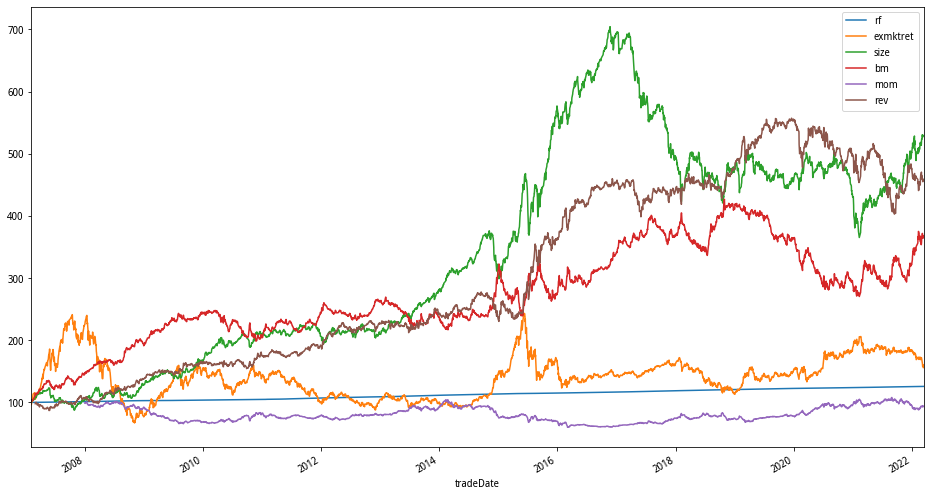

In [75]:
((factors_daily+1).cumprod()*100).plot()

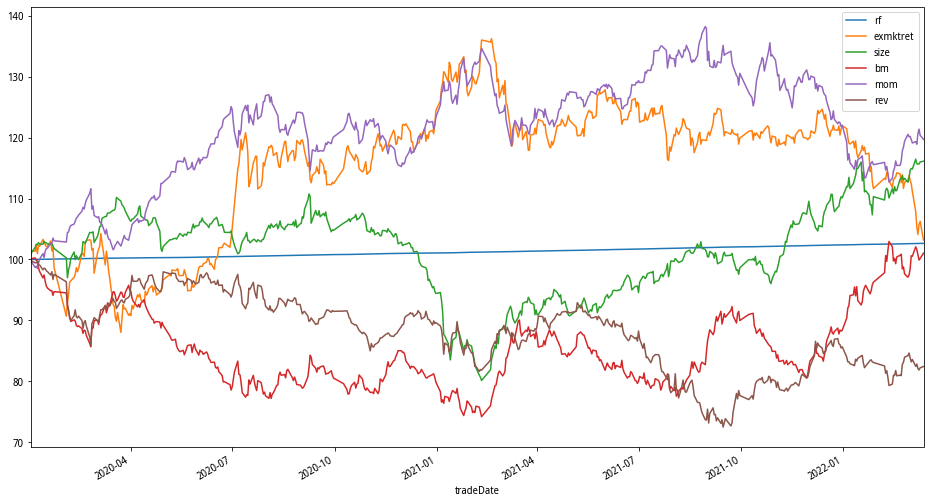

In [76]:
((factors_daily.loc['2020':]+1).cumprod()*100).plot()

In [77]:
factors_daily.to_pickle('./data/factors/factors_daily.pkl')